## Import the required modules


In [1]:
import PIL
import PIL.Image
import cv2
import time
import numpy as np

import ipywidgets as widgets
import threading
import time

import random
import colorsys

## Display webcam within notebook
I wrote these helper functions to display the webcam feed from OpenCV directly within the Jupyter notebook. Some code has been adapted from [here](https://github.com/NicksonYap/Jupyter-Webcam).

The first function `notebook_display_init` will display a new image in the output of the cell. It will return an ID which is passed to `notebook_display_update` to update that image with a new one subsequently.

In [2]:
from io import BytesIO
import IPython.display

# Use 'jpeg' instead of 'png' (~5 times faster)

def notebook_display_init(a, fmt='jpeg', _id=True):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    return IPython.display.display(obj, display_id=_id)

def notebook_display_update(a, fmt='jpeg', display_id=None):
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    obj = IPython.display.Image(data=f.getvalue())
    if display_id:
        display_id.update(obj)
    else:
        IPython.display.clear_output(wait=True)
        return IPython.display.display(obj, display_id=True)


Disable scrolling in IPython output for the whole image to show up nicely

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Prepare the overlay
We will download the overlay onto the board. Then we will load the corresponding DPU model.

I modified `dpu_conf.vh` in the sources and compiled my own overlay with B1600 and RAM_USAGE_HIGH.

In [4]:
from pynq_dpu import DpuOverlay
from pynq_dpu.edge.dnndk.tf_yolov3_voc_py.tf_yolov3_voc import *

# Self-compiled
#overlay = DpuOverlay("./mymodel/dpu.bit")
#overlay.load_model("./mymodel/dpu_tf_yolov3.elf")

# Precompiled
overlay = DpuOverlay("dpu.bit")
overlay.load_model("/home/xilinx/jupyter_notebooks/pynq-dpu/dpu_tf_yolov3.elf")

print("Bitstream and model downloaded")

Bitstream and model downloaded


## Constants

Yolo V2 and V3 predict offsets from a predetermined set of boxes with 
particular height-width ratios; those predetermined set of boxes are the 
anchor boxes. We will use the predefined [anchors](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/tf_yolov3_voc_py/model_data/yolo_anchors.txt).

In [5]:
anchor_list = [10,13,16,30,33,23,30,61,62,45,59,119,116,90,156,198,373,326]
anchor_float = [float(x) for x in anchor_list]
anchors = np.array(anchor_float).reshape(-1, 2)

We will use the `get_class()` function in `tf_yolov3_voc` module to
get class names from predefined [class names](https://github.com/Xilinx/Vitis-AI/blob/v1.1/mpsoc/vitis_ai_dnndk_samples/tf_yolov3_voc_py/image/voc_classes.txt).

Depending on the number of classes, we will define a unique color for each class.

In [6]:
classes_path = "./pynq-dpu/img/voc_classes.txt"
class_names = get_class(classes_path)

num_classes = len(class_names)
hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
colors = list(map(lambda x: 
                  (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), 
                  colors))
random.seed(0)
random.shuffle(colors)
random.seed(None)

We can define some DPU-related parameters, such as DPU kernel name and
input/output node names.

In [7]:
KERNEL_CONV="tf_yolov3"
CONV_INPUT_NODE="conv2d_1_convolution"
CONV_OUTPUT_NODE1="conv2d_59_convolution"
CONV_OUTPUT_NODE2="conv2d_67_convolution"
CONV_OUTPUT_NODE3="conv2d_75_convolution"

## Helper functions

#### Drawing bounding boxes
We now define a custom function that draws the bounding boxes around the identified objects after we have the classification results.

*Note: This is where I modified the function to filter for "person" class names. This means only "person" will be detected.*

In [8]:
def draw_boxes(image, boxes, scores, classes):
    for i, bbox in enumerate(boxes):
        y1, x1, y2, x2 = bbox # [top, left, bottom, right] = bbox
        
        score, class_index = scores[i], classes[i]
        class_name = class_names[class_index]
        color = colors[class_index]
        label = '{}: {:.4f}'.format(class_name, score) 
        
        if class_name not in ['person']:
            continue
        
        # Draw rectangle
        box_thickness = 2
        cv2.rectangle(image, (x1, y1), (x2, y2), color, box_thickness)
        
        # Draw text
        text_thickness = 2
        text_size = 0.5
        cv2.putText(image, label, (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, text_size, color, text_thickness, cv2.LINE_AA)

    return image

#### Predicting classes
We need to define a function that evaluates the scores and makes predictions
based on the provided class names.

In [ ]:
def evaluate(yolo_outputs, image_shape, class_names, anchors):
    score_thresh = 0.1
    anchor_mask = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
    boxes = []
    box_scores = []
    input_shape = np.shape(yolo_outputs[0])[1 : 3]
    input_shape = np.array(input_shape)*32

    for i in range(len(yolo_outputs)):
        _boxes, _box_scores = boxes_and_scores(
            yolo_outputs[i], anchors[anchor_mask[i]], len(class_names), 
            input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = np.concatenate(boxes, axis = 0)
    box_scores = np.concatenate(box_scores, axis = 0)

    mask = box_scores >= score_thresh
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(len(class_names)):
        class_boxes_np = boxes[mask[:, c]]
        class_box_scores_np = box_scores[:, c]
        class_box_scores_np = class_box_scores_np[mask[:, c]]
        nms_index_np = nms_boxes(class_boxes_np, class_box_scores_np) 
        class_boxes_np = class_boxes_np[nms_index_np]
        class_box_scores_np = class_box_scores_np[nms_index_np]
        classes_np = np.ones_like(class_box_scores_np, dtype = np.int32) * c
        boxes_.append(class_boxes_np)
        scores_.append(class_box_scores_np)
        classes_.append(classes_np)
    boxes_ = np.concatenate(boxes_, axis = 0)
    scores_ = np.concatenate(scores_, axis = 0)
    classes_ = np.concatenate(classes_, axis = 0)

    return (boxes_, scores_, classes_)

## Main webcam loop
This cell of code will setup the DPU, webcam and then show the webcam stream continuously.

**To stop the webcam stream, you must interrupt the kernel:**
- From the menu bar, click on ***Kernel > Interrupt***

Creating DPU kernel
Video: <VideoCapture 0x7f77fa21d0>


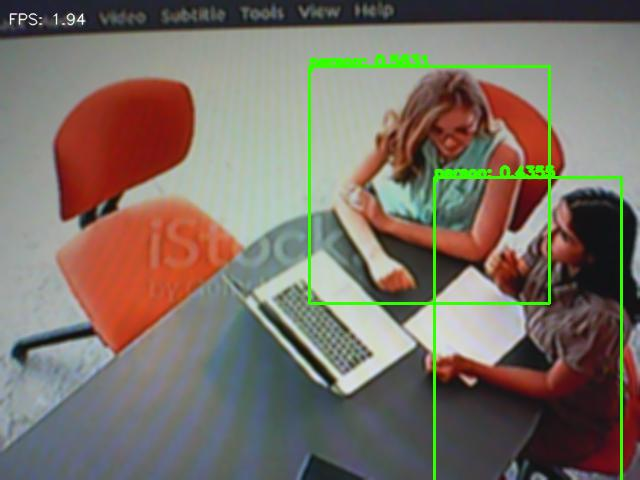

In [ ]:
# We create DPU kernel and task.
print("Creating DPU kernel")
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_CONV)
task = n2cube.dpuCreateTask(kernel, 0)

# Find a valid camera device and open it
for cam_index in range(10):
    cam = cv2.VideoCapture(cam_index)
    if (cam is not None) and cam.isOpened():
        print("Video:", cam)
        break

# Set resolution for the camera
cam.set(cv2.CAP_PROP_FRAME_WIDTH, 1920)
cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 1080)

# Create webcam display in notebook
ret_val, img = cam.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_size = img.shape[:2]
nb_display = notebook_display_init(img)

# For the tensor sizes, we can get it now because it is constant
# Don't waste CPU time in the while-loop.
input_len = n2cube.dpuGetInputTensorSize(task, CONV_INPUT_NODE)
conv_sbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE1)
conv_mbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE2)
conv_lbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE3)

store_out = widgets.Output()
with store_out:
    %store class_names
    %store image_size
    store_out.clear_output()

# Webcam activity
while True:
    try:
        start_time = time.time()

        # My webcam was in BGR mode, so I had to convert it
        ret_val, img = cam.read()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # img = cv2.flip(img, 1)
        img = cv2.blur(img,(5,5))  
        image_size = img.shape[:2]
        image_data = np.array(pre_process(img, (416, 416)), dtype=np.float32)
        
        #Now we execute the DPU task to classify an input picture.
        #input_len = n2cube.dpuGetInputTensorSize(task, CONV_INPUT_NODE)
        n2cube.dpuSetInputTensorInHWCFP32(
            task, CONV_INPUT_NODE, image_data, input_len)

        n2cube.dpuRunTask(task)

        #conv_sbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE1)
        conv_out1 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE1, 
                                                       conv_sbbox_size)
        conv_out1 = np.reshape(conv_out1, (1, 13, 13, 75))

        #conv_mbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE2)
        conv_out2 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE2, 
                                                       conv_mbbox_size)
        conv_out2 = np.reshape(conv_out2, (1, 26, 26, 75))

        #conv_lbbox_size = n2cube.dpuGetOutputTensorSize(task, CONV_OUTPUT_NODE3)
        conv_out3 = n2cube.dpuGetOutputTensorInHWCFP32(task, CONV_OUTPUT_NODE3, 
                                                       conv_lbbox_size)
        conv_out3 = np.reshape(conv_out3, (1, 52, 52, 75))

        yolo_outputs = [conv_out1, conv_out2, conv_out3]


        # We can call the evaluate() function defined previously now. Depending on how many objects can be identified in the picture, the function returns a
        # list of bounding box coordinates, a list of probability scores, and a list of class indexes.
        boxes, scores, classes = evaluate(yolo_outputs, image_size, class_names, anchors)
        
        # Store into IPython database, so that it can be retrieved from another notebook.
        store_out = widgets.Output()
        with store_out:
            %store boxes
            %store classes
            store_out.clear_output()

        # Once we have all the bounding boxes, classes, and scores, we can feed them to the
        # draw_boxes() function to draw the bounding boxes over each recognized object.
        _ = draw_boxes(img, boxes, scores, classes)

        elapsed_time = time.time() - start_time
        fps = 1 / elapsed_time;

        cv2.putText(img, f"FPS: {fps:.2f}", (8, 24), cv2.FONT_HERSHEY_SIMPLEX, 
                    0.5, (255,255,255), 1, cv2.LINE_AA)
        notebook_display_update(img, display_id=nb_display)

    except KeyboardInterrupt:
        cam.release()
        cv2.destroyAllWindows()
        n2cube.dpuDestroyTask(task)
        n2cube.dpuDestroyKernel(kernel)
        print("Exited gracefully.")

## Cleanup

Remember to clean up when you are done. This function closes the camera, OpenCV and N2Cube instances.

In [ ]:
cam.release()
cv2.destroyAllWindows()
n2cube.dpuDestroyTask(task)
n2cube.dpuDestroyKernel(kernel)

The End